In [11]:
import sys
# add path for my packages
sys.path.append('C:\\Users\\katsuya2\\OneDrive - University of Illinois - Urbana\\Documents\\Python Scripts\\my_packages')
import re
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import ast
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.stats import norm
import scipy.stats as stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm import tqdm
from pathlib import Path
from glob import glob
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, make_scorer, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor


%precision 3
%matplotlib inline

# use my matplotlib style
style_p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/my_packages")
plt.style.use(Path(style_p, 'my_rc_setting.mplstyle'))

In [12]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

# all glass data
# glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
# glass_data['ratio'] = glass_data['length'] / glass_data['width']
# glass_data = glass_data.drop(['corrcoef'], axis=1)
# glass_data['volume'] = np.pi*(glass_data['width']**2)*glass_data['length']/4 - np.pi*(glass_data['width']**3)/12

glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data = glass_data.drop(['corrcoef'], axis=1)
original_data = pd.read_csv(Path(p, 'New_SPP.csv'))
combined_data = pd.concat([glass_data, original_data], axis=0)
combined_data['volume'] = np.pi*(combined_data['width']**2)*combined_data['length']/4 - np.pi*(combined_data['width']**3)/12
combined_data['ratio'] = combined_data['length'] / combined_data['width']

combined_data = combined_data[(combined_data['width'] < 60) & (combined_data['length'] < 130)]
combined_data = combined_data.reset_index(drop=True)

# all ITO data
ito_data = pd.read_csv(Path(p, '111623_ito_training.csv'))
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)

# # further control the dataset so that all aspect ratio in glass can fall into the range of ITO's ratio
# ito_ratio_min = ito_data['ratio'].min()
# ito_ratio_max = ito_data['ratio'].max()

# glass_data = glass_data[(glass_data['ratio'] > ito_ratio_min) & (glass_data['ratio'] < ito_ratio_max)]
# glass_data = glass_data.reset_index(drop=True)
# print(glass_data.shape)

# # further control the dataset so that all width and length in glass can fal into the range of ITO's
# ito_width_min = ito_data['width'].min()
# ito_width_max = ito_data['width'].max()
# ito_length_min = ito_data['length'].min()
# ito_length_max = ito_data['length'].max()

# glass_data = glass_data[(glass_data['width'] > ito_width_min) & (glass_data['width'] < ito_width_max)]
# glass_data = glass_data[(glass_data['length'] > ito_length_min) & (glass_data['length'] < ito_length_max)]
# glass_data = glass_data.reset_index(drop=True)
# print(glass_data.shape)

# Randomly sample 1000 rows from each dataframe
# glass_data = glass_data.sample(n=1000, random_state=42)
# glass_data = glass_data.reset_index(drop=True)
# ito_data = ito_data.sample(n=1000, random_state=42)
# ito_data = ito_data.reset_index(drop=True)
# print(glass_data.shape)

combined_data.shape

(1701, 7)

In [49]:
# define testing data from actual experiments
# exp_glass_data = pd.read_csv(Path(p, '100323_ZJ_exp_glass_final.csv'))
exp_glass_data = pd.read_csv(Path(p, 'SPP_AuNRs_exp_short.csv'))
exp_ito_data = pd.read_csv(Path(p, '100323_ZJ_exp_ito_final.csv'))
exp_ito_data = exp_ito_data.drop(47)
exp_ito_data = exp_ito_data.reset_index(drop=True)

# control distribution
# exp_glass_data = exp_glass_data[(exp_glass_data['width'] < 28) & (exp_glass_data['length'] < 100) & (exp_glass_data['length'] > 70)] 
# exp_glass_data = exp_glass_data[(exp_glass_data['length'] > 80) & (exp_glass_data['length'] < 95)] 
# exp_glass_data = exp_glass_data[(exp_glass_data['width'] > 28) & (exp_glass_data['width'] < 31)] 
# exp_glass_data = exp_glass_data.reset_index(drop=True)

exp_ito_data = exp_ito_data[(exp_ito_data['length'] > 80) & (exp_ito_data['length'] < 95)] 
exp_ito_data = exp_ito_data[(exp_ito_data['width'] > 28) & (exp_ito_data['width'] < 31)] 
exp_ito_data = exp_ito_data.reset_index(drop=True)

# create the specific number of data
# exp_glass_data = exp_glass_data.sample(50, random_state=42)
exp_ito_data = exp_ito_data.sample(30, random_state=42)

# X_exp_glass = exp_glass_data.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'aspect_ratio', 'volume', 'surface_area'], axis=1)
X_exp_glass = exp_glass_data.drop(['imax', 'width', 'length'], axis=1)
yw_exp_glass = exp_glass_data['width']
yl_exp_glass = exp_glass_data['length']

X_exp_ito = exp_ito_data.drop(['exp_ene', 'exp_dfs', 'imax', 'width', 'length', 'fitting', 'ratio', 'volume', 'surface_area'], axis=1)
yw_exp_ito = exp_ito_data['width']
yl_exp_ito = exp_ito_data['length']

print(X_exp_glass.shape, X_exp_ito.shape)

(26, 2) (30, 2)


In [50]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

# all glass data
# glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
# glass_data['ratio'] = glass_data['length'] / glass_data['width']
# glass_data = glass_data.drop(['corrcoef'], axis=1)
# glass_data['volume'] = np.pi*(glass_data['width']**2)*glass_data['length']/4 - np.pi*(glass_data['width']**3)/12

glass_data = pd.read_csv(Path(p, '090723_glass_training.csv'))
glass_data = glass_data.drop(['corrcoef'], axis=1)

original_data = pd.read_csv(Path(p, 'New_SPP.csv'))
glass_data = pd.concat([glass_data, original_data], axis=0)
glass_data['volume'] = np.pi*(glass_data['width']**2)*glass_data['length']/4 - np.pi*(glass_data['width']**3)/12
glass_data['ratio'] = glass_data['length'] / glass_data['width']
glass_data = glass_data[(glass_data['width'] < 38) & (glass_data['length'] < 130)]
glass_data = glass_data.reset_index(drop=True)
print(glass_data.shape)

(1587, 7)


In [51]:
p = Path("C:/Users/katsuya2/OneDrive - University of Illinois - Urbana/Documents/Python Scripts/input_data/SPP2023")

# all ITO data
ito_data = pd.read_csv(Path(p, '111623_ito_training.csv'))
ito_data['ratio'] = ito_data['length'] / ito_data['width']
ito_data = ito_data.drop(['corrcoef'], axis=1)
print(ito_data.shape)

# further control the dataset so that all aspect ratio in glass can fall into the range of ITO's ratio
ito_ratio_min = ito_data['ratio'].min()
ito_ratio_max = ito_data['ratio'].max()

glass_data = glass_data[(glass_data['ratio'] > ito_ratio_min) & (glass_data['ratio'] < ito_ratio_max)]
glass_data = glass_data.reset_index(drop=True)
print(glass_data.shape)

# further control the dataset so that all width and length in glass can fal into the range of ITO's
ito_width_min = ito_data['width'].min()
ito_width_max = ito_data['width'].max()
ito_length_min = ito_data['length'].min()
ito_length_max = ito_data['length'].max()

glass_data = glass_data[(glass_data['width'] > ito_width_min) & (glass_data['width'] < ito_width_max)]
glass_data = glass_data[(glass_data['length'] > ito_length_min) & (glass_data['length'] < ito_length_max)]
glass_data = glass_data.reset_index(drop=True)
print(glass_data.shape)

# Randomly sample 1000 rows from each dataframe
glass_data = glass_data.sample(n=1000, random_state=42)
glass_data = glass_data.reset_index(drop=True)
ito_data = ito_data.sample(n=1000, random_state=42)
ito_data = ito_data.reset_index(drop=True)
print(glass_data.shape)

(3292, 6)
(1412, 7)
(1256, 7)
(1000, 7)


In [63]:
def calc_dif(idx, ito_data, glass_data):
    Eres_glass = glass_data['eres'][idx]
    Linewidth_glass = glass_data['linewidth'][idx]
    AR_glass = glass_data['ratio'][idx]

    upper_min = ito_data[ito_data['ratio'] > AR_glass]['ratio'].min()
    lower_max = ito_data[ito_data['ratio'] < AR_glass]['ratio'].max()

    if abs(upper_min - AR_glass) > abs(lower_max - AR_glass):
        AR_ito_closest = lower_max
    else:
        AR_ito_closest = upper_min

    Eres_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['eres']
    Linewidth_ito = ito_data[ito_data['ratio'] == AR_ito_closest]['linewidth']
    dEres_IG = Eres_ito - Eres_glass
    dLinewidth_IG = Linewidth_ito - Linewidth_glass
    return dEres_IG, dLinewidth_IG


def calculate_mean(lst):
    return sum(lst) / len(lst)


def numerical_method(ito_data, glass_data, target_nsub):
    ito_nsub = 1.96
    glass_nsub = 1.52
    dnsub_IG = ito_nsub - glass_nsub
    dEres_IG_list = []
    dLinewidth_IG_list = []
    for idx in range(glass_data.shape[0]):
        dEres_IG, dLinewidth_IG = calc_dif(idx, ito_data, glass_data)
        if (dEres_IG.shape == (1,)) and (dLinewidth_IG.shape == (1,)): 
            dEres_IG_list.append(dEres_IG.values)
            dLinewidth_IG_list.append(dLinewidth_IG.values)

    dEres_IG_mean = calculate_mean(dEres_IG_list)
    dLinewidth_IG_mean = calculate_mean(dLinewidth_IG_list)
    C = dEres_IG_mean / dnsub_IG
    D = dLinewidth_IG_mean / dnsub_IG
    target_Eres = C*(target_nsub - glass_nsub) + glass_data['eres']
    target_Linewidth = D*(target_nsub - glass_nsub) + glass_data['linewidth']
    return target_Eres, target_Linewidth

In [64]:
# glass_data = glass_data.sample(1000, random_state=42)
# define input and output
X_glass = glass_data.drop(['width', 'length', 'imax', 'ratio', 'volume'], axis=1)
yw_glass = glass_data['width']
yl_glass = glass_data['length']
print(X_glass.shape)

# X_glass = combined_data.drop(['width', 'length', 'imax', 'ratio', 'volume'], axis=1)
# yw_glass = combined_data['width']
# yl_glass = combined_data['length']

# ito_data = ito_data.sample(1000, random_state=42)
# define input and output
X_ito = ito_data.drop(['width', 'length', 'imax', 'ratio'], axis=1)
yw_ito = ito_data['width']
yl_ito = ito_data['length']

(1000, 2)


## Figure 3A glass to glass

In [75]:
X_glass = combined_data.drop(['width', 'length', 'imax', 'ratio', 'volume'], axis=1)
yw_glass = combined_data['width']
yl_glass = combined_data['length']
print(X_glass.shape)

(1701, 2)


In [76]:
# parameters for GridSearchCV class
# param_grid = {'max_depth': range(1, 31)}

param_grid = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10]
}

# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred0 = gsw.predict(X_exp_glass)

rel_errw0 = (abs(yw_exp_glass-yw_pred0)/yw_exp_glass)*100
rmspew0 = (sum(rel_errw0**2)/len(yw_pred0)) ** 0.5
maew0 = mean_absolute_error(yw_exp_glass, yw_pred0)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred0 = gsl.predict(X_exp_glass)

rel_errl0 = (abs(yl_exp_glass-yl_pred0)/yl_exp_glass)*100
rmspel0 = (sum(rel_errl0**2)/len(yl_pred0)) ** 0.5
mael0 = mean_absolute_error(yl_exp_glass, yl_pred0)

print(rmspew0, rmspel0)
print(maew0, mael0)

10.258764612160402 7.996913084051155
2.4059334246153834 4.405201923846155


Text(0.01, 0.95, 'A')

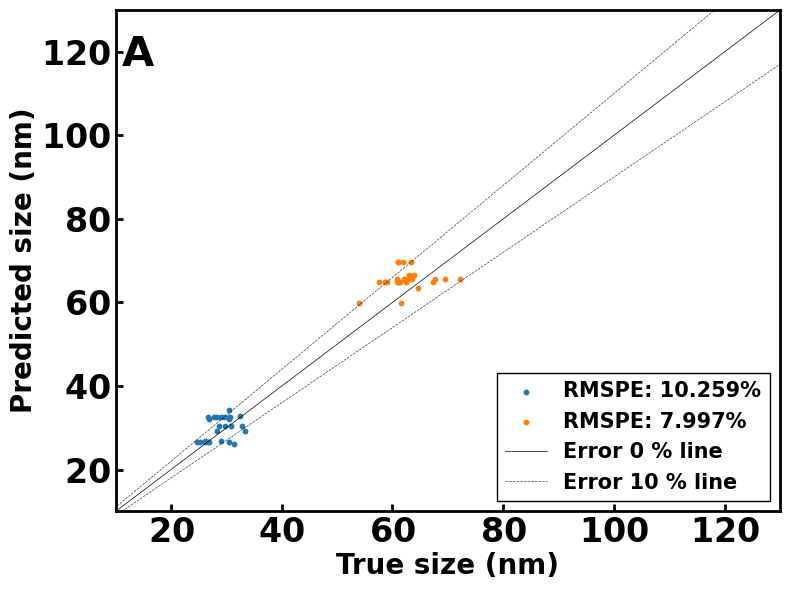

In [77]:
fig, ax = plt.subplots()

ax.scatter(yw_exp_glass, yw_pred0, s=10, label=f'RMSPE: {round(rmspew0, 3)}%')
ax.scatter(yl_exp_glass, yl_pred0, s=10, label=f'RMSPE: {round(rmspel0, 3)}%')
    
x = np.arange(-1, 181)
ax.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax.set_xlabel('True size (nm)')
ax.set_ylabel('Predicted size (nm)')
# ax.set_xticks([2.5, 3.0, 3.5, 4.0, 4.5])
# ax.set_yticks([1.5, 1.7, 1.9])
ax.set_xlim(10, 130)
ax.set_ylim(10, 130)
ax.legend(loc='lower right', fontsize=15)
ax.text(0.01, 0.95, 'A', ha='left', va='top', transform=ax.transAxes, fontsize=30)

## FIgure 3B glass to ITO

In [78]:
# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred1 = gsw.predict(X_exp_ito)

rel_errw1 = (abs(yw_exp_ito-yw_pred1)/yw_exp_ito)*100
rmspew1 = (sum(rel_errw1**2)/len(yw_pred1)) ** 0.5
maew1 = mean_absolute_error(yw_exp_ito, yw_pred1)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred1 = gsl.predict(X_exp_ito)

rel_errl1 = (abs(yl_exp_ito-yl_pred1)/yl_exp_ito)*100
rmspel1 = (sum(rel_errl1**2)/len(yl_pred1)) ** 0.5
mael1 = mean_absolute_error(yl_exp_ito, yl_pred1)

print(rmspew1, rmspel1)
print(maew1, mael1)

7.287475207036925 12.35037890443088
1.7321221389721406 9.52287574927462


Text(0.01, 0.95, 'B')

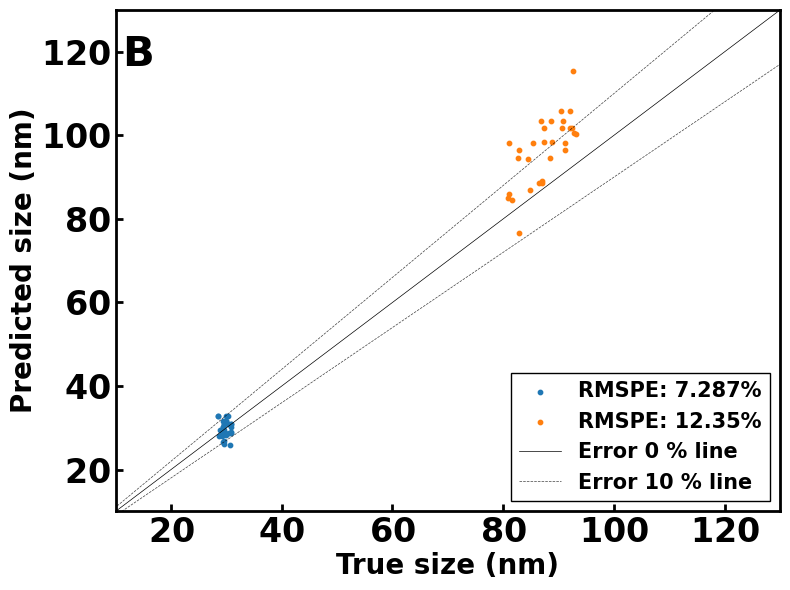

In [87]:
fig, ax = plt.subplots()

ax.scatter(yw_exp_ito, yw_pred1, s=10, label=f'RMSPE: {round(rmspew1, 3)}%')
ax.scatter(yl_exp_ito, yl_pred1, s=10, label=f'RMSPE: {round(rmspel1, 3)}%')
    
x = np.arange(-1, 181)
ax.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax.set_xlabel('True size (nm)')
ax.set_ylabel('Predicted size (nm)')
ax.set_xlim(10, 130)
ax.set_ylim(10, 130)
ax.legend(loc='lower right', fontsize=15)
ax.text(0.01, 0.95, 'B', ha='left', va='top', transform=ax.transAxes, fontsize=30)

## Figure 3C corrected glass to ITO

In [81]:
ITO_nsub = 1.96
# ITO_Eres, ITO_Linewidth = numerical_method(ito_data, glass_data, target_nsub=ITO_nsub)
ITO_Eres, ITO_Linewidth = numerical_method(ito_data, combined_data, target_nsub=ITO_nsub)

X_glass['eres'] = ITO_Eres
X_glass['linewidth'] = ITO_Linewidth
X_glass

,eres,linewidth
0,1.926742,0.154759
1,1.631668,0.098587
2,1.732926,0.103273
3,1.547233,0.088554
4,1.801430,0.118656
...,...,...
1696,1.448402,0.082073
1697,1.375667,0.083231
1698,1.515075,0.084679
1699,1.522961,0.081227


In [82]:
# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_glass, yw_glass)
yw_pred2 = gsw.predict(X_exp_ito)

rel_errw2 = (abs(yw_exp_ito-yw_pred2)/yw_exp_ito)*100
rmspew2 = (sum(rel_errw2**2)/len(yw_pred2)) ** 0.5
maew2 = mean_absolute_error(yw_exp_ito, yw_pred2)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_glass, yl_glass)
yl_pred2 = gsl.predict(X_exp_ito)

rel_errl2 = (abs(yl_exp_ito-yl_pred2)/yl_exp_ito)*100
rmspel2 = (sum(rel_errl2**2)/len(yl_pred2)) ** 0.5
mael2 = mean_absolute_error(yl_exp_ito, yl_pred2)

print(rmspew2, rmspel2)
print(maew2, mael2)

10.540851764806886 8.747832850645336
2.6379047787397782 6.664850921115922


Text(0.01, 0.95, 'C')

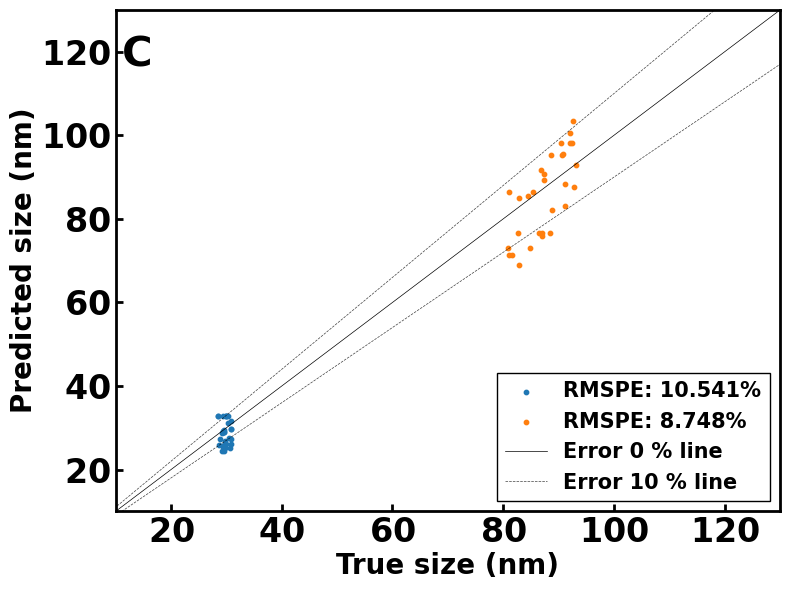

In [88]:
fig, ax = plt.subplots()

ax.scatter(yw_exp_ito, yw_pred2, s=10, label=f'RMSPE: {round(rmspew2, 3)}%')
ax.scatter(yl_exp_ito, yl_pred2, s=10, label=f'RMSPE: {round(rmspel2, 3)}%')
    
x = np.arange(-1, 181)
ax.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax.set_xlabel('True size (nm)')
ax.set_ylabel('Predicted size (nm)')
ax.set_xlim(10, 130)
ax.set_ylim(10, 130)
ax.legend(loc='lower right', fontsize=15)
ax.text(0.01, 0.95, 'C', ha='left', va='top', transform=ax.transAxes, fontsize=30)

## Figure 3D ITO to ITO

In [90]:
X_ito.shape

(1000, 2)

In [84]:
# Initialize GridSearchCV class
gsw = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsw.fit(X_ito, yw_ito)
yw_pred3 = gsw.predict(X_exp_ito)

rel_errw3 = (abs(yw_exp_ito-yw_pred3)/yw_exp_ito)*100
rmspew3 = (sum(rel_errw3**2)/len(yw_pred3)) ** 0.5
maew3 = mean_absolute_error(yw_exp_ito, yw_pred3)

# Initialize GridSearchCV class
gsl = GridSearchCV(estimator=DecisionTreeRegressor(),
                  param_grid=param_grid,
                  cv=10, scoring="neg_mean_squared_error")

# fitting
gsl.fit(X_ito, yl_ito)
yl_pred3 = gsl.predict(X_exp_ito)

rel_errl3 = (abs(yl_exp_ito-yl_pred3)/yl_exp_ito)*100
rmspel3 = (sum(rel_errl3**2)/len(yl_pred1)) ** 0.5
mael3 = mean_absolute_error(yl_exp_ito, yl_pred3)

print(rmspew3, rmspel3)
print(maew3, mael3)

9.079778634157748 7.906078027025639
2.2661471019721025 5.995536666666665


Text(0.01, 0.95, 'D')

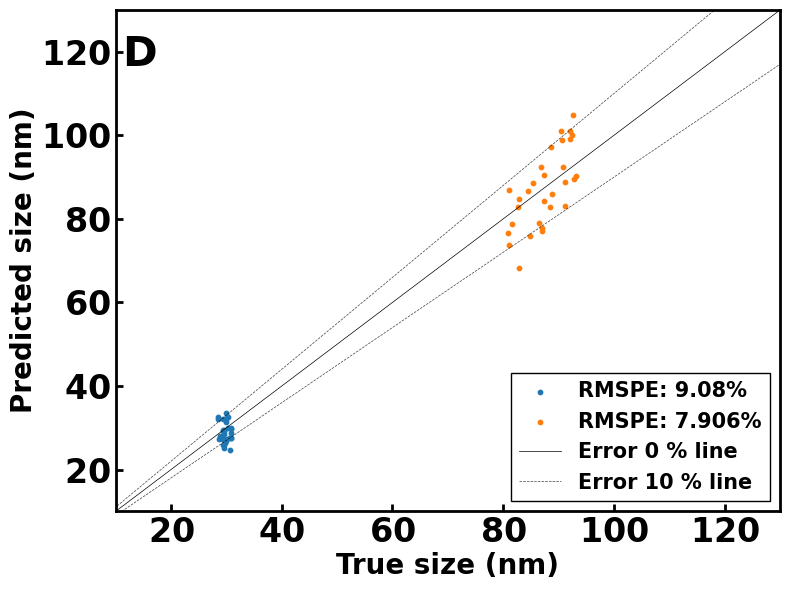

In [89]:
fig, ax = plt.subplots()

ax.scatter(yw_exp_ito, yw_pred3, s=10, label=f'RMSPE: {round(rmspew3, 3)}%')
ax.scatter(yl_exp_ito, yl_pred3, s=10, label=f'RMSPE: {round(rmspel3, 3)}%')
    
x = np.arange(-1, 181)
ax.plot(x, x, c='k', lw=0.5, label='Error 0 % line')
ax.plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
ax.plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

ax.set_xlabel('True size (nm)')
ax.set_ylabel('Predicted size (nm)')
ax.set_xlim(10, 130)
ax.set_ylim(10, 130)
ax.legend(loc='lower right', fontsize=15)
ax.text(0.01, 0.95, 'D', ha='left', va='top', transform=ax.transAxes, fontsize=30)

## Final Plot

C:\Users\katsuya2\AppData\Local\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
C:\Users\katsuya2\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


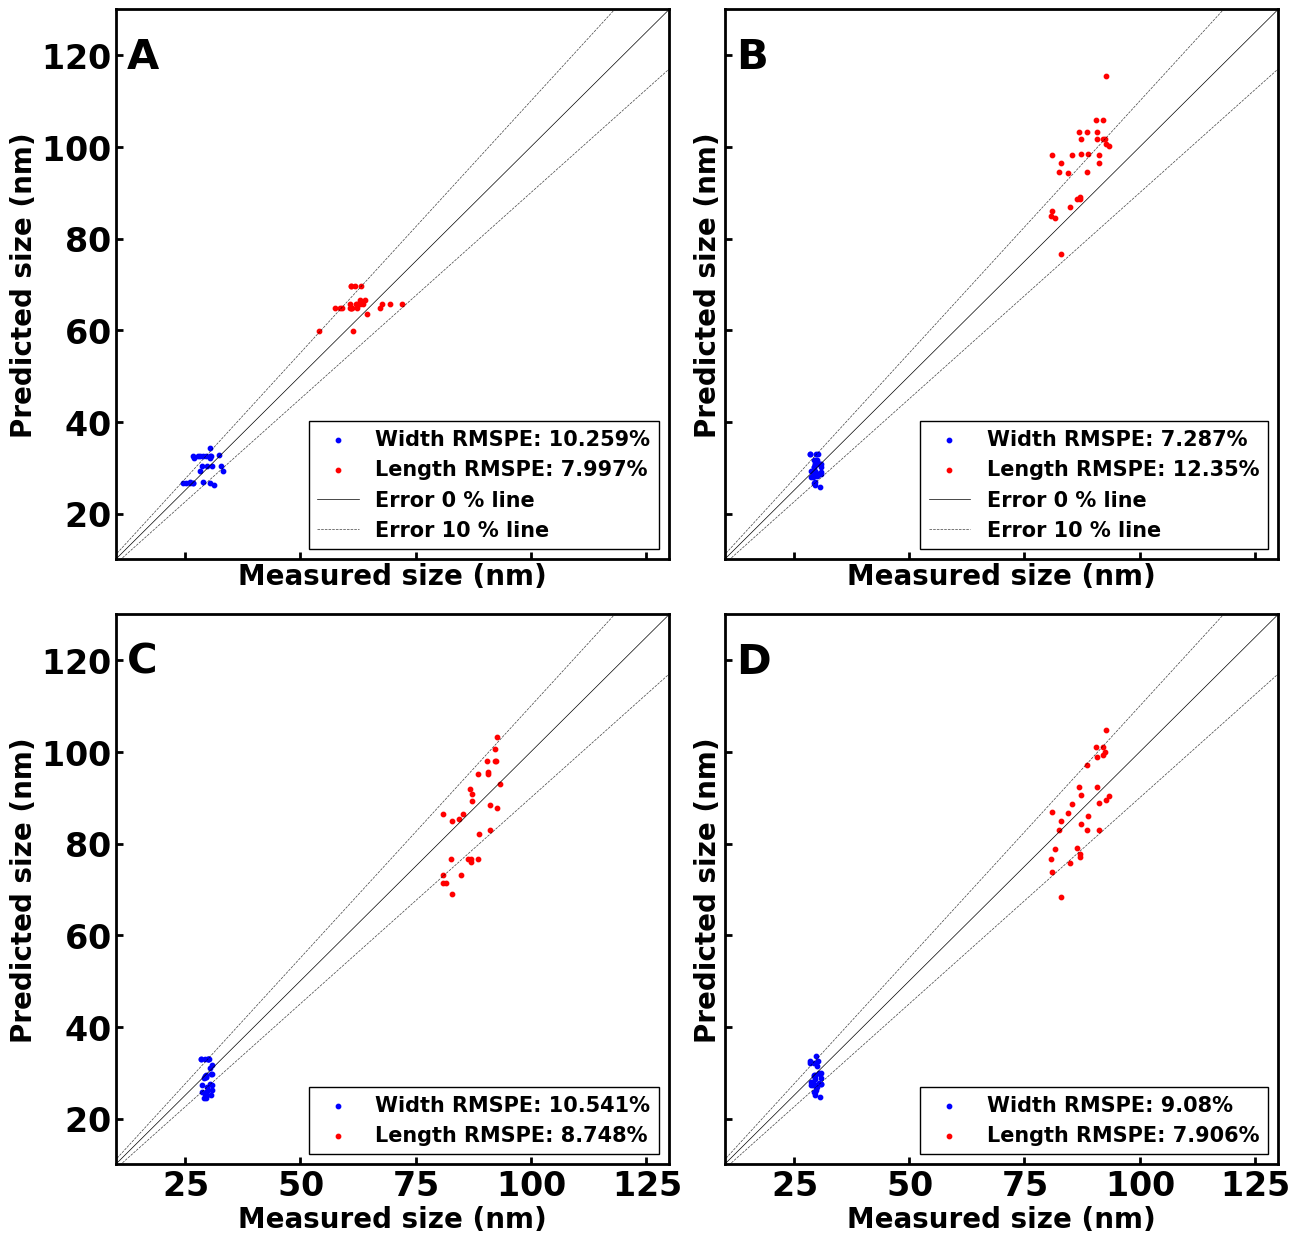

In [86]:
# Create a figure with two subplots, sharing the x-axis
fig, axs = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

axs[0, 0].scatter(yw_exp_glass, yw_pred0, s=10, c='b', label=f'Width RMSPE: {round(rmspew0, 3)}%')
axs[0, 0].scatter(yl_exp_glass, yl_pred0, s=10, c='r', label=f'Length RMSPE: {round(rmspel0, 3)}%')

x = np.arange(-1, 181)
axs[0, 0].plot(x, x, c='k', lw=0.5, label='Error 0 % line')
axs[0, 0].plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
axs[0, 0].plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

axs[0, 0].set_xlabel('Measured size (nm)')
axs[0, 0].set_ylabel('Predicted size (nm)')
axs[0, 0].set_xlim(10, 130)
axs[0, 0].set_ylim(10, 130)
axs[0, 0].legend(loc='lower right', fontsize=15)
axs[0, 0].text(0.02, 0.95, 'A', ha='left', va='top', transform=axs[0, 0].transAxes, fontsize=30)

axs[0, 1].scatter(yw_exp_ito, yw_pred1, s=10, c='b', label=f'Width RMSPE: {round(rmspew1, 3)}%')
axs[0, 1].scatter(yl_exp_ito, yl_pred1, s=10, c='r', label=f'Length RMSPE: {round(rmspel1, 3)}%')

x = np.arange(-1, 181)
axs[0, 1].plot(x, x, c='k', lw=0.5, label='Error 0 % line')
axs[0, 1].plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, label='Error 10 % line', alpha=0.75)
axs[0, 1].plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

axs[0, 1].set_xlabel('Measured size (nm)')
axs[0, 1].set_ylabel('Predicted size (nm)')
axs[0, 1].set_xlim(10, 130)
axs[0, 1].set_ylim(10, 130)
axs[0, 1].legend(loc='lower right', fontsize=15)
axs[0, 1].text(0.02, 0.95, 'B', ha='left', va='top', transform=axs[0, 1].transAxes, fontsize=30)


axs[1, 0].scatter(yw_exp_ito, yw_pred2, s=10, c='b', label=f'Width RMSPE: {round(rmspew2, 3)}%')
axs[1, 0].scatter(yl_exp_ito, yl_pred2, s=10, c='r', label=f'Length RMSPE: {round(rmspel2, 3)}%')

axs[1, 0].plot(x, x, c='k', lw=0.5)
axs[1, 0].plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, alpha=0.75)
axs[1, 0].plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

axs[1, 0].set_xlabel('Measured size (nm)')
axs[1, 0].set_ylabel('Predicted size (nm)')
axs[1, 0].set_xlim(10, 130)
axs[1, 0].set_ylim(10, 130)
axs[1, 0].legend(loc='lower right', fontsize=15)
axs[1, 0].text(0.02, 0.95, 'C', ha='left', va='top', transform=axs[1, 0].transAxes, fontsize=30)


axs[1, 1].scatter(yw_exp_ito, yw_pred3, s=10, c='b', label=f'Width RMSPE: {round(rmspew3, 3)}%')
axs[1, 1].scatter(yl_exp_ito, yl_pred3, s=10, c='r', label=f'Length RMSPE: {round(rmspel3, 3)}%')

axs[1, 1].plot(x, x, c='k', lw=0.5)
axs[1, 1].plot(x, 1.1*x, c='k', linestyle='--', lw=0.5, alpha=0.75)
axs[1, 1].plot(x, 0.9*x, c='k', linestyle='--', lw=0.5, alpha=0.75)

axs[1, 1].set_xlabel('Measured size (nm)')
axs[1, 1].set_ylabel('Predicted size (nm)')
axs[1, 1].set_xlim(10, 130)
axs[1, 1].set_ylim(10, 130)
axs[1, 1].legend(loc='lower right', fontsize=15)
axs[1, 1].text(0.02, 0.95, 'D', ha='left', va='top', transform=axs[1, 1].transAxes, fontsize=30)

plt.subplots_adjust(hspace=0)  # Remove the space between plots